# Model 1 : User Features only

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
train_data = pd.read_csv('data/modelling/train_data_14_features.csv')
train_data.head()

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders,reordered
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000,10,5.9,17.272727,2.636364,3.721774,35791,0.776480,11.195803,1.0
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556,10,5.9,17.272727,2.636364,4.277492,1946,0.713772,11.099692,1.0
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000,10,5.9,17.272727,2.636364,4.191097,5526,0.652009,11.177705,0.0
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000,10,5.9,17.272727,2.636364,4.760037,6476,0.740735,9.955837,0.0
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000,10,5.9,17.272727,2.636364,5.622767,3751,0.657158,10.616636,1.0


### Establish Features for the model

In [4]:
# Set feature and target variables
features_cols = ['user_id', 'product_id', 'u_mean_order_dow', 'u_mean_days_between_orders', 'u_mean_products', 'u_total_orders']
X = train_data[features_cols]
y = train_data.reordered

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Establish Baseline Model to compare against
This DummyClassifier doesn't learn from the input data but rather generates predictions based on predefined rules.
The rules are either most frequent, uniform, prior, constant, or stratified.
As the dataset is quite imbalanced, I've selected stratified as the strategy parameter.

In [5]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(random_state=12, strategy='stratified') 
clf_dummy.fit(X_train, y_train)

y_dummy_pred = clf_dummy.predict(X_test)

f1_score(y_test, y_dummy_pred)

0.09720730008426147

### Confusion Matrix

In [26]:
pd.crosstab(y_test, y_dummy_pred)

col_0,0.0,1.0
reordered,,
0.0,1724610,186746
1.0,187179,20131


In [43]:
# confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_dummy_pred, cmap='GnBu').plot(values_format='')
pd.crosstab(y_test, y_dummy_pred)

col_0,0.0,1.0
reordered,,
0.0,1724610,186746
1.0,187179,20131


In [6]:
pd.crosstab(y_test, y_dummy_pred, normalize='all')

col_0,0.0,1.0
reordered,,
0.0,0.814007,0.088143
1.0,0.088348,0.009502


In [7]:
print(classification_report(y_test, y_dummy_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90   1911356
         1.0       0.10      0.10      0.10    207310

    accuracy                           0.82   2118666
   macro avg       0.50      0.50      0.50   2118666
weighted avg       0.82      0.82      0.82   2118666



### Train the model

In [8]:
# Calculate imbalance ratio to pass to classifier
positive_class = y_train.sum()
negative_class = len(y_train) - positive_class
scale_pos_weight = negative_class / positive_class

# Instantiate the classifier
xgb_cl = xgb.XGBClassifier(objective='binary:logistic',
                           seed=123, 
                           scale_pos_weight=scale_pos_weight)

# Fit the classifier to the train set
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Predict with Train set

In [9]:
y_train_pred = xgb_cl.predict(X_train)

f1_score(y_train, y_train_pred)

0.23749412246628487

#### Confusion Matrix

In [39]:
pd.crosstab(y_train, y_train_pred)

col_0,0,1
reordered,,
0.0,3591553,2142928
1.0,249011,372503


In [44]:
# ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred).plot(values_format='')

In [45]:
# ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='all')
pd.crosstab(y_train, y_train_pred, normalize='all').round(3)

col_0,0,1
reordered,,
0.0,0.565,0.337
1.0,0.039,0.059


#### Train scores

In [12]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75   5734481
         1.0       0.15      0.60      0.24    621514

    accuracy                           0.62   6355995
   macro avg       0.54      0.61      0.49   6355995
weighted avg       0.86      0.62      0.70   6355995



### Predict with Test set

In [13]:
y_test_pred = xgb_cl.predict(X_test)

f1_score(y_test, y_test_pred)

0.233575748413905

#### Confusion Matrix

In [20]:
pd.crosstab(y_test, y_test_pred)

col_0,0,1
reordered,,
0.0,1195553,715803
1.0,85246,122064


In [46]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='GnBu')

In [49]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred).plot(values_format='')
pd.crosstab(y_test, y_test_pred, normalize='all').round(3)

col_0,0,1
reordered,,
0.0,0.564,0.338
1.0,0.040,0.058


#### Test Scores

In [41]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.63      0.75   1911356
         1.0       0.15      0.59      0.23    207310

    accuracy                           0.62   2118666
   macro avg       0.54      0.61      0.49   2118666
weighted avg       0.86      0.62      0.70   2118666



### Cross-validation

In [52]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=3, random_state=123, shuffle=True)

cv_results = cross_val_score(xgb_cl, X, y, cv=kfold, scoring='f1', verbose=1)

print(cv_results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.23347832577515382


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished


### Feature Importance

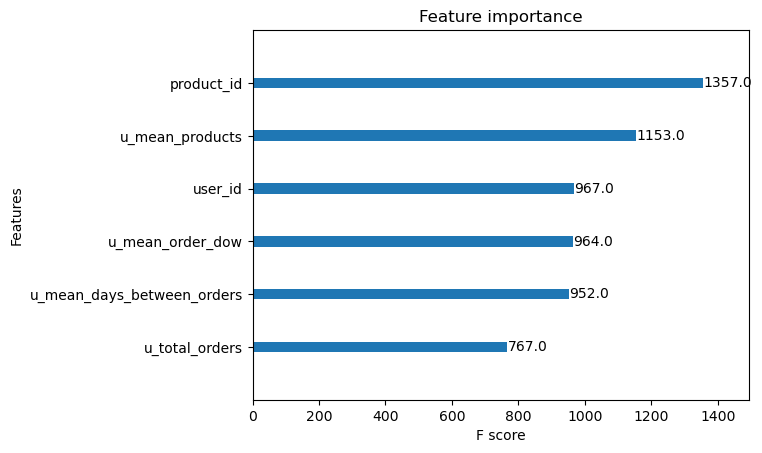

In [54]:
xgb.plot_importance(xgb_cl, grid=False);